In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

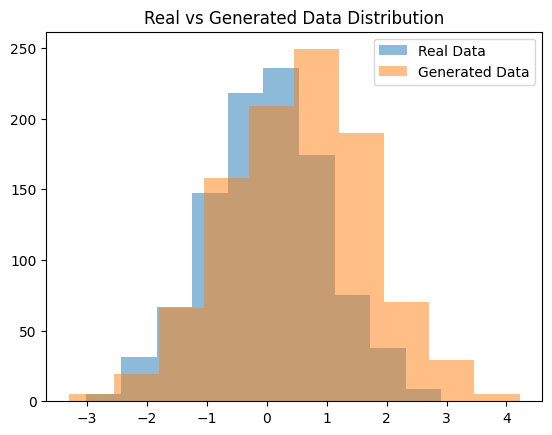

In [5]:

np.random.seed(43)
real_data = np.random.normal(0, 1, 1000)
generated_data = np.random.normal(0.5, 1.2, 1000)

plt.hist(real_data, alpha=0.5, label='Real Data')
plt.hist(generated_data, alpha=0.5, label='Generated Data')
plt.legend()
plt.title('Real vs Generated Data Distribution')
plt.show()


In [6]:
def build_generator(input_dim, output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, input_dim=input_dim, activation='relu'),
        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.Dense(output_dim, activation='tanh')
    ])
    return model

def build_discriminator(input_dim):
    model = tf.keras.Sequential([ 
        tf.keras.layers.Dense(256, input_dim=input_dim,activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


In [8]:
generator = build_generator(100, 784)
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               12928     
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 dense_5 (Dense)             (None, 784)               201488    
                                                                 
Total params: 247440 (966.56 KB)
Trainable params: 247440 (966.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
discriminator = build_discriminator(784)
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               200960    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 233985 (914.00 KB)
Trainable params: 233985 (914.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
def generate_noise(batch_size, noise_dim):
    return np.random.normal(0,1,size=(batch_size, noise_dim))

bs,nd = 64,100
noise = generate_noise(batch_size=bs,noise_dim=nd)

print(noise.shape,noise[0][:10])


(64, 100) [-0.60272245 -0.5565732  -0.12567435  1.42231805 -0.10845608  0.97378041
 -0.95868342  0.36972364  0.21890863  0.30123978]


In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

fake_output = tf.random.uniform((64,1))
gen_loss = generator_loss(fake_output)
# print(gen_loss)
print(gen_loss.numpy())

real_output = tf.random.uniform((64,1))
disc_loss = discriminator_loss(real_output, fake_output)
print(disc_loss.numpy())


0.47190255
1.4935963


In [14]:
@tf.function
def train_step(real_images):
    noise = generate_noise(batch_size, noise_dim)
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

# # Example usage (assuming we have a dataset)
# for epoch in range(num_epochs):
#     for batch in dataset:
#         gen_loss, disc_loss = train_step(batch)
#     print(f"Epoch {epoch + 1}, Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss:.4f}")


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} Index out of range using input dim 2; input has only 2 dims [Op:StridedSlice] name: strided_slice/

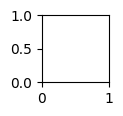

In [16]:
def generate_and_plot_images(generator, noise_dim, num_examples=16):
    noise = generate_noise(num_examples, noise_dim)
    generated_images = generator(noise, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(num_examples):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i, :, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
generate_and_plot_images(generator, nd)
